## XG Boost Base

### Data Preparation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import sys

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImpute

sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray

try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
# Reading Data
dir_name="../data/member_001"
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)

In [ ]:
# Creating one singular df
data_read=xr.merge([mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2])
tmp_data=data_read.to_dataframe().reset_index()

tmp_data=tmp_data.drop(columns=['bnds','TLONG', 'TLAT', 'time_bnds'])

chl_data=chl.Chl.to_dataframe().reset_index()
chl_data_socat=chl.Chl_socat.to_dataframe().reset_index()
pco2_data=pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat=pco2.pCO2_socat.to_dataframe().reset_index()

tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
tmp_data["Chl"]=chl_data["Chl"]
tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]

features_socat = ['time', 'xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time', 'xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data.loc[:,features_socat]
combined=tmp_data.loc[:,features]

# drop rows where pco2 or pco2_socat == NA
combined_socat.dropna(subset = ["pCO2_socat"], inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]
combined.dropna(subset = ["pCO2"], inplace=True)
combined= combined[combined['pCO2']!=0]

X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']


### Imputation

In [ ]:
# Two Different Imputation Methods
# KNNImputer
# imp = KNNImputer(n_neighbors=2)
# X=imp.fit_transform(X)
# X_socat=imp.fit_transform(X_socat)

# SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X=imp.fit_transform(X)
X_socat=imp.fit_transform(X_socat)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 73)


### XG Boost Modeling

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05, .07], #so called `eta` value
              'n_estimators': [30,50,100]}


if xgboost is not None: 
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_grid = GridSearchCV(xgb_reg,
                        parameters,
                        cv = 7,
                        n_jobs = 5,
                        verbose=True)
    xgb_grid.fit(X_train, y_train)
    

### Final Result

Test Set RMSE:28.43698261274142

Whole Grid Rmse:37.709863752151215

In [ ]:
final_model =xgb_grid.best_estimator_
y_pred = final_model.predict(X_test)
val_error = np.sqrt(mean_squared_error(y_test, y_pred,squared=True)) # Not shown
print("Best Test RMSE:", val_error)           

In [ ]:
## Whole Grid
y_pred=final_model.predict(X)
final_rmse=np.sqrt(mean_squared_error(y, y_pred,squared=True))
error=y-y_pred
final_rmse

### Visualization of the Residual

In [39]:
import cmocean as cm

In [40]:
combined["residual"]=np.abs(error)
result_data=combined[["time","xlon","ylat","residual"]]
cols=result_data.columns.tolist()
cols=[cols[0],cols[2],cols[1],cols[3]]
result_data=result_data[cols]
result_data.columns=['time','lat','lon','residual']



In [55]:
ds=df_to_xarray(result_data)

<ipython-input-54-630af28a422d>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(ds['lon'], ds['lat'], ds['residual'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)


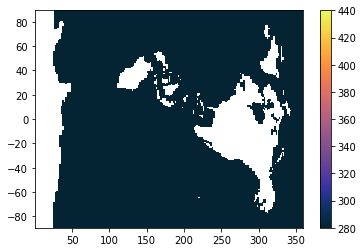

In [54]:
plt.pcolor(ds['lon'], ds['lat'], ds['residual'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)
plt.colorbar()

In [ ]:
a=ds.residual.hvplot(groupby="time",width=512,height=512, widget_type='scrubber', widget_location='bottom')
a